# Bibliothèques

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 51)
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn : apprentissage automatique
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config # Pour afficher les pipelines
set_config(display='diagram')
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# import warnings
# warnings.filterwarnings("ignore")

# Import du dataset

In [2]:
data = pd.read_csv('diabetic_data_130US_hospital.csv', sep=';')

In [3]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Principales informations

## Source et vue d'ensemble du dataset  

Ce dataset est hébergé sur le site opensource du "Center for Machine Learning and Intelligent Systems" de l'Université de Californie, qui regroupe des données permettant de faire du machine learning. 

Notre dataset traite du diabète et représente les données sur 10 ans (1999-2008), de 130 hôpitaux américains, des patients ayant été admis (patients hospitalisés) pour ce type de problème : https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008

Le dataset compte 101766 exemples et 50 features. Chaque ligne correspond à l'admission unique d'un patient. A noter qu'un patient peut être admis plusieurs fois. Le nombre de patients total ayant été admis sur la période est de 71518. 


In [4]:
data.shape

(101766, 50)

In [5]:
data['encounter_id'].nunique(), data['patient_nbr'].nunique()

(101766, 71518)

## Quelles sont mes variables ?

Le dataset présente des variables relatives aux caractéristiques physiques du patient, à la nature de sa prise en charge médicale (spécialité du médecin, temps d'hospitalisation...), à ses traitements médicaux et à ses résultats de tests de sanguins. 

Voici le détail : 

**encounter_id** : identifiant unique de l'admission 

**patient_nbr** : identifiant unique du patient  

**race** : 'Caucasian', 'AfricanAmerican', 'Other', 'Asian', 'Hispanic'

**gender** : homme ou femme  

**age** : groupé par des intervalles de 10 années  

**weight** : poids du patient en livre (A TRADUIRE EN KG)  

**admission_type_id** : id correspondant à 8 modalités (Emergency, Urgent, Elective, Newborn, Not Available, NULL, Trauma Center, Not Mapped  (voir dans le détail à quoi cela correspond))  

**discharge_disposition_id** : lieu de transfert après guérison - 26 modalités (voir fichier excel) - A la maison, dans un autre service, etc.    

**admission_source_id** : raison de l'admission (recommandation médicale/urgence/enfant malade..) - 17 modalités.   

**time_in_hospital** : nombre de jours entre l'admission et la sortie (va de 1 à 14 jours) 

**payer_code** : unique ID assigné à chaque compagnie (RETROUVER NOM ENTIER DE CHAQUE MODALITE)   

**medical_specialty** : correspond à la spécialité du médecin qui a pris en charge le patient à son arrivée - 73 modalités 

**num_lab_procedures** : nombre de tests labo faits pendant l'hospitalisation  

**num_procedures** : nombre de procédures (interventions) autre que les tests en labo  

**num_medications** : nombre de médicaments administrés lors de l'encounter (ou Number of distinct generic names administered during the encounter) - A VERIFIER   

**number_outpatient** : Nombre de visites ambulatoires du patient dans l'année précédant la consultation (consultation externe)   

**number_emergency** : Nombre de visites aux urgences du patient dans l'année précédant la consultation  

**number_inpatient** : Nombre de visites hospitalières du patient dans l'année précédant la consultation  

**diag_1/2/3** : Premier, second et diagnostique additionnel. Correspond au code ICD9 (documentation pour la classification : https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9)  

**number_diagnoses** : nombre de diagnostics déclarés dans le système  

**max_glu_serum** : 4 modalités - Glycémie à jeun (A VERIFIER)  

**A1Cresult** : HbA1c = hémoglobine glyquée  

**Medications : metformin -> metformin-pioglitazone** : types de médicaments pris avec 4 modalités (régulier, pas pris, augmenté, diminué)   

**change** : indique s'il y a eu un changement dans la traitement pour le diabète, soit dans la posologie, soit dans le nom du médicament  

**diabetesMed** : prescription de médicaments pour le diabète ou pas  

**readmitted** :  le patient a-t-il été réadmis au bout de 30 jours max, à plus de 30 jours ou pas réadmis ?   

In [6]:
#############
# A faire ? Requalifier les colonnes pour une meilleure compréhension ?
#############

data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [7]:
# Indique la nature et le nombre de modalités pour chacune des colonnes

####################
# A FAIRE : ajouter un paramètre dans la fonction permettant de sélectionner les colonnes dont on veut avoir le détail
# -> def modalites(df, columns=[]):
####################

def modalites(df):
    for i in df.columns:
        print(f'{i}: {df[i].unique()}')
        print(f'Nb de modalités : {df[i].value_counts().count()}\n')

modalites(data)

encounter_id: [  2278392    149190     64410 ... 443854148 443857166 443867222]
Nb de modalités : 101766

patient_nbr: [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
Nb de modalités : 71518

race: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
Nb de modalités : 6

gender: ['Female' 'Male' 'Unknown/Invalid']
Nb de modalités : 3

age: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
Nb de modalités : 10

weight: ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
Nb de modalités : 10

admission_type_id: [6 1 2 3 4 5 8 7]
Nb de modalités : 8

discharge_disposition_id: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
Nb de modalités : 26

admission_source_id: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
Nb de modalités : 17

time_in_hospital: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
Nb de modalités : 14

payer_

Nb de modalités : 717

diag_2: ['?' '250.01' '250' '250.43' '157' '411' '492' '427' '198' '403' '288'
 '998' '507' '174' '425' '456' '401' '715' '496' '428' '585' '250.02'
 '410' '999' '996' '135' '244' '41' '571' '276' '997' '599' '424' '491'
 '553' '707' '286' '440' '493' '242' '70' 'V45' '250.03' '357' '511' '196'
 '396' '197' '414' '250.52' '577' '535' '413' '285' '53' '780' '518' '150'
 '566' '250.6' '867' '486' 'V15' '8' '788' '340' '574' '581' '228' '530'
 '250.82' '786' '294' '567' '785' '512' '305' '729' '250.51' '280' '648'
 '560' '618' '444' '38' 'V10' '578' '277' '781' '250.42' '278' '426' '584'
 '462' '402' '153' '272' '733' '34' '881' '203' '250.41' '250.13' '293'
 '245' '250.12' '558' '787' '342' '573' '626' '303' '250.53' '458' '710'
 '415' 'V42' '284' '569' '759' '682' '112' '292' '435' '290' '250.93'
 '642' '536' '398' '319' '711' 'E878' '446' '255' 'V44' '250.7' '784'
 '300' '562' '162' '287' '447' '789' '790' '591' '200' '154' '304' '117'
 '847' '852' '250.83' '250.


chlorpropamide: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

glimepiride: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

acetohexamide: ['No' 'Steady']
Nb de modalités : 2

glipizide: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

glyburide: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

tolbutamide: ['No' 'Steady']
Nb de modalités : 2

pioglitazone: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

rosiglitazone: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

acarbose: ['No' 'Steady' 'Up' 'Down']
Nb de modalités : 4

miglitol: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

troglitazone: ['No' 'Steady']
Nb de modalités : 2

tolazamide: ['No' 'Steady' 'Up']
Nb de modalités : 3

examide: ['No']
Nb de modalités : 1

citoglipton: ['No']
Nb de modalités : 1

insulin: ['No' 'Up' 'Steady' 'Down']
Nb de modalités : 4

glyburide-metformin: ['No' 'Steady' 'Down' 'Up']
Nb de modalités : 4

glipizide-metformin: ['No' 'Steady']
Nb de modalités : 2

glimepiride-pioglitazone: ['No' 'Ste

## La target : réadmission ou non du patient

Notre target est la variable 'readmitted' : il s'agira de prédire si, au regard des caractéristiques ci-dessus, le patient sera réadmis ou non ultérieurement dans le service diabétologie.

Nous avons là deux possibilités :  
    - effectuer une classification mutliclasse (dans ce cas, vérifier le déséquilibre des classes et le corriger avec la méthode Smote par exemple)   
    - rassembler la target en une variable binaire (0 = pas de réadmission / 1 = réadmission (>30 et <30))

In [8]:
data.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

# Traitement nécessaire avant exploration des données

## Analyse des caractères anormaux du dataframe

Nous observons des "?" : nous les remplaçons par des Nan.
Nous observons de nombreux "None" : pour l'instant, nous ne les changeons pas en null (donc pas de drop) car elles font partie de modalités de deux features importantes (max_glu_serum et A1Cresult). 

**Questions** : 
- faut-il supprimer les "-" de la variable "medical_specialty" ? 
- faut-il bien considérer les None comme des valeurs nulles ? 

In [9]:
##########
# A FAIRE : refactoriser le code en mettant les 3 étapes dans une fonction def
##########

# Quelles sont les colonnes qui contiennent des "?"

def columns_with_interrogation(df): 
    list = []
    [list.append(i) for i in df.columns if np.any(df[i] == '?')] # list comprehension  
    return list

# Combien de lignes par colonnes sont concernées ? 

interrogation = columns_with_interrogation(data)

for i in interrogation:
    number = data[i] == '?'
    total = number.sum()
    print(f'La colonne "{i}" en contient : {total}')

La colonne "race" en contient : 2273
La colonne "weight" en contient : 98569
La colonne "payer_code" en contient : 40256
La colonne "medical_specialty" en contient : 49949
La colonne "diag_1" en contient : 21
La colonne "diag_2" en contient : 358
La colonne "diag_3" en contient : 1423


In [10]:
# Remplacement des ? par des nan

data = data.replace({'?' : np.nan})
columns_with_interrogation(data) # on vérifie qu'on n'a plus de colonnes impactées

[]

In [11]:
# Vérification de la présence des None

def columns_with_None(data):
    list = []
    [list.append(i) for i in data.columns if np.any(data[i] == 'None')] # list comprehension  
    return list

None_columns = columns_with_None(data)

for i in None_columns:
    number = data[i] == 'None'
    total = number.sum()
    print(f'La colonne "{i}" en contient : {total}')

La colonne "max_glu_serum" en contient : 96420
La colonne "A1Cresult" en contient : 84748


In [12]:
# les "?" ont bien été remplacés par des Nan

data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [13]:
# La modalité "Unknown/Invalid" de colonne 'gender' contient un caratère spécial, et est de toute façon à considérer 
# comme un Null, donc nous la qualifions en nan.  

data['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [14]:
data = data.replace({'Unknown/Invalid' : np.nan})

In [15]:
data['gender'].value_counts()

Female    54708
Male      47055
Name: gender, dtype: int64

## Suppression de l'Id

Variable integer inutile qui va parasiter notre modèle.

In [16]:
data = data.drop(columns=['encounter_id'])

## Vérification des doublons

On ne constate aucun doublon.

In [17]:
data.duplicated(keep=False).sum()

0

## Encodage de la target

Notre intérêt ici est de savoir si le patient, suite à son séjour hospitalier, risque d'être de nouveau hospitalisé. Nous ne prenons pas en compte la granularité de temps (à moins ou plus de 30 jours). Nous optons donc pour une variable binaire et non multiclasse.

In [18]:
data = data.replace({'readmitted' : {'NO' : 0, '>30' : 1, '<30' : 1}})

In [19]:
# nb d'exemples pour chaque modalité de la colonne readmitted

data.readmitted.value_counts()

0    54864
1    46902
Name: readmitted, dtype: int64

# Itération 1 : baseline

**Objectif** : créer un modèle prédictif simple, basé sur une analyse exploratoire et une data préparation sommaires afin de comprendre un peu mieux la structure du dataset et de pouvoir élaborer une ébauche de l'application demandée. 

## Analyse de forme des données

**- Target** : readmitted - la classe est équilibrée (0 : 53% / 1 : 46%)  
**- Lignes et colonnes** : 101766 lignes et  49 colonnes  
**- Types de variables** : int64 = 13, object = 36 dont 5 avec plus de 10 modalités  
**- Valeurs manquantes**: 7 colonnes ont des valeurs manquantes dont 'weight' à hauteur de 96%. 'medical_specialty' et 'payer_code' manquent respectivement à 50% et 40%. 

### Structure du dataset

In [20]:
# On travaille sur une copie du dataset initial

baseline = data.copy()

In [21]:
# La target 'readmitted'

def analyse_target(data) : 
    number = data.readmitted.value_counts()
    percentage = data.readmitted.value_counts(normalize=True).round(3)*100
    analyse_target = {'number': number, '%': percentage}
    analyse_target_1 = pd.DataFrame(analyse_target)
    return analyse_target_1
    
analyse_target(baseline)

,number,%
0,54864,53.9
1,46902,46.1


**Question** : Quel est le degré de documentation du code qui est demandé ? Exemple documentation de la fonction ci-dessus.

In [22]:
# Nombre de Lignes et colonnes

baseline.shape

(101766, 49)

### Types de variables

A ce stade, nous avons 36 variables qualitatives dont 5 contiennent plus de 10 modalités, et 13 quantitatives.  

In [23]:
baseline.dtypes.value_counts()

object    36
int64     13
dtype: int64

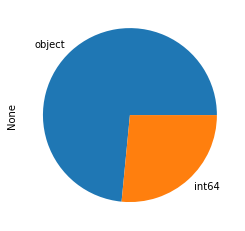

In [24]:
# Répartition du type de variables

##################
# A faire : intégrer les valeurs dans le pie et retirer le None
#################

baseline.dtypes.value_counts().plot.pie()
plt.show()

In [25]:
def analyse_dtypes_object(data):
    return data.select_dtypes(include=('object')).nunique().sort_values(ascending=False)

analyse_dtypes_object(baseline)

diag_3                      789
diag_2                      748
diag_1                      716
medical_specialty            72
payer_code                   17
age                          10
weight                        9
race                          5
glipizide                     4
glyburide-metformin           4
insulin                       4
miglitol                      4
acarbose                      4
rosiglitazone                 4
pioglitazone                  4
glyburide                     4
chlorpropamide                4
nateglinide                   4
repaglinide                   4
metformin                     4
glimepiride                   4
A1Cresult                     4
max_glu_serum                 4
tolazamide                    3
acetohexamide                 2
glipizide-metformin           2
change                        2
metformin-pioglitazone        2
metformin-rosiglitazone       2
glimepiride-pioglitazone      2
diabetesMed                   2
troglita

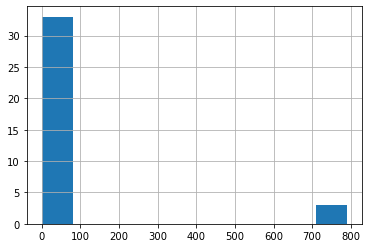

In [26]:
# Affiche le plot des modalités pour toutes les variables catégorielles

#############
# A FAIRE : reprendre le graph avec d'autres bins pour plus de précision sur l'intervalle [0 - 100]
############

baseline.select_dtypes(include=('object')).nunique().hist()
plt.show()

### Valeurs nulles

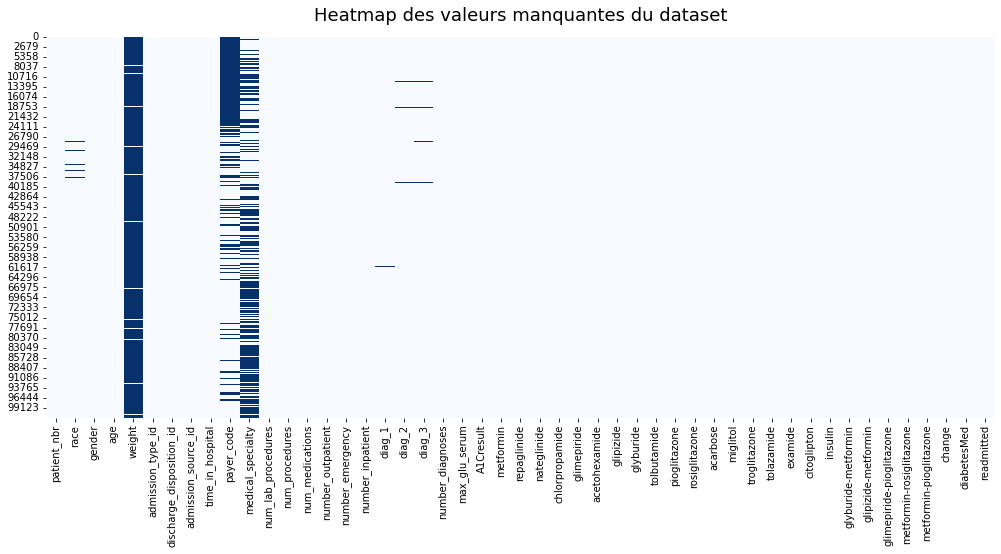

In [27]:
def map_missing_values(data):
    plt.figure(figsize=(17,7))
    heatmap = sns.heatmap(data.isna(), cbar=False, cmap="Blues")
    heatmap.set_title('Heatmap des valeurs manquantes du dataset',
    fontdict={'fontsize':18}, pad=16);
    
map_missing_values(baseline)

In [28]:
# On affiche les valeurs nulles en ordre desc des 10 premières colonnes

def check_null_values(df):
    nb_null = df.isnull().sum().sort_values(ascending=False).head(10)
    percentage_null = df.isnull().sum()*100/len(df)
    percentage_null = percentage_null.sort_values(ascending=False).head(10).round(1)
    null = {'nombre_null' : nb_null,'%_null' : percentage_null}
    data = pd.DataFrame(data = null)
    return data

check_null_values(baseline)

,nombre_null,%_null
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0
gender,3,0.0
patient_nbr,0,0.0
tolazamide,0,0.0


## Pre-processing

### Suppression des valeurs nulles

Pour notre modèle experimental (baseline), nous décidons de supprimer les colonnes qui ont plus de 40% de valeurs nulles(weight, medical_specialty, payer_code) et toutes les lignes possédant au moins une valeur nulle. 
Notre dataset se compose désormais de 98 052 exemples et 46 colonnes.

In [29]:
# Suppression des colonnes ayant plus de 39% de valeurs nulles (isna)
# Suppression des lignes ayant au moins une valeur nulle(dropna)

##############
# VOIR si refacto en personnalisant le pourcentage de façon optionnelle
# def delete_columns_null_more_40_percent(data):
#     data = data[data.columns[data.isna().sum()/data.shape[0] <0.4]]
#     return data
#############

baseline = baseline[baseline.columns[baseline.isna().sum()/baseline.shape[0] <0.3]]
baseline = baseline.dropna()

In [30]:
check_null_values(baseline)

,nombre_null,%_null
patient_nbr,0,0.0
tolazamide,0,0.0
acetohexamide,0,0.0
glipizide,0,0.0
glyburide,0,0.0
tolbutamide,0,0.0
pioglitazone,0,0.0
rosiglitazone,0,0.0
acarbose,0,0.0
miglitol,0,0.0


In [31]:
baseline.shape

(98052, 46)

### Sélection des variables et split

On exclut :  
- les variables qui n'ont qu'une modalité (examide/citoglipton) car elles n'apportent rien au modèle
- les variables à plus de 10 modalités (diag_1/2/3) car elles vont créer de multiples dimensions lors de l'encodage, ce qui peut être lourd et et embrouiller l'algorithme. 
- la variable "patient_nbr" qui est un ID

Notre dataset contient désormais : 98053 exemples et 39 features

**Questions** : 
- 3 variables qualitatives correspondent à des modalités mais sont déjà encodées de façon ordinale : que faire ? 

In [32]:
baseline = baseline.drop(columns=['diag_3', 'diag_2', 'diag_1', 'citoglipton', 'examide', 'metformin-rosiglitazone', 'patient_nbr'], axis=1)

In [33]:
baseline.shape

(98052, 39)

In [109]:
# Création du X et du y

# X = baseline.drop(columns=['readmitted'], axis=1)
X = baseline[['time_in_hospital','num_lab_procedures','num_procedures','num_medications',
              'number_outpatient','number_emergency', 'number_inpatient', 'number_diagnoses','age']]
y = baseline[['readmitted']]

In [96]:
X['age'].dtypes

dtype('int64')

In [35]:
y[0:5]

,readmitted
1,1
2,0
3,0
4,0
5,1


=> N'ai pris que les variables catégorielles car cela faisait planter mes algo et les résultats étaient identiques.

In [110]:
# Split du dataset entre un jeu de données de train et de test

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=5, stratify=y)

print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

Train set : (78441, 9)
Test set : (19611, 9)


### Encodage et normalisation

#### Transformation de la variable "age"

La colonne "age" est classé selon un intervalle avec 10 modalités (object). 
Point d'attention : cette donnée perd en qualité car on ne sait pas comment la donnée initiale a été transformée.  
Creuser pour savoir comment traiter cette variable plus efficacement. En attendant, nous allons la transformer en variable numérique en prenant la moyenne des extrêmes de l'intervalle. On aurait pu aussi envisager de faire un Ordinal encorder. 

**Question** : voir comment gérer cette question des intervalles -> si je les garde en l'état, mon algorithme va les considérer comme des variables catégorielles => Beaucoup trop lourd pour le modèle ?

In [111]:
# baseline = baseline.replace({'age' : 
#                             {'[0-10)' : 5, 
#                              '[10-20)' : 15, 
#                              '[20-30)' : 25, 
#                              '[30-40)' : 35, 
#                              '[40-50)' : 45,
#                              '[50-60)' : 55,
#                              '[60-70)' : 65,
#                              '[70-80)' : 75,
#                              '[80-90)' : 80, 
#                              '[90-100)' : 95}
#                             })

X = X.replace({'age' : 
                            {'[0-10)' : 5, 
                             '[10-20)' : 15, 
                             '[20-30)' : 25, 
                             '[30-40)' : 35, 
                             '[40-50)' : 45,
                             '[50-60)' : 55,
                             '[60-70)' : 65,
                             '[70-80)' : 75,
                             '[80-90)' : 80, 
                             '[90-100)' : 95}
                            })

In [112]:
# baseline.head(2)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,15,1,1,7,3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,1
2,AfricanAmerican,Female,25,1,1,7,2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0


In [113]:
X.head(2)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age
1,3,59,0,18,0,0,0,9,15
2,2,11,5,13,2,0,1,6,25


In [114]:
X.dtypes

time_in_hospital      int64
num_lab_procedures    int64
num_procedures        int64
num_medications       int64
number_outpatient     int64
number_emergency      int64
number_inpatient      int64
number_diagnoses      int64
age                   int64
dtype: object

In [39]:
# baseline.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted'],
      dtype='object')

In [94]:
baseline["age"].dtypes

dtype('int64')

#### Pipeline de preprocessing

On crée un pipeline de pré-processing de façon à pouvoir transformer nos données plus facilement, à éviter d'avoir de la fuite de données (dataleakage) ou des données mal transformées. 

Nous avons des variables catégorielles pour lesquelles il serait plus pertinent de faire un OrdinalEncoder (mettre un poids en fonction du degré d'importance) mais pour notre baseline, nous allons plutôt utiliser le OneHotEncoder. Ce dernier représente chaque classe de façon binaire et les sépare en plusieurs dimensions. On évite ainsi les problème d'affection de poids sur la variable encodée. 

In [115]:
# Distinction entre les variables numériques et catégorielles

numerical_features = X.select_dtypes(include=['float', 'integer']).columns.values
categorical_features = X.select_dtypes(include=['object']).columns.values

In [116]:
categorical_features

array([], dtype=object)

In [117]:
# handle_unknown = 'ignore' : pallier au fait que nous n'avons pas dans le X_test le même nombre de classes/modalités

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(sparse = False,  handle_unknown = 'ignore'))

In [118]:
# make_column_transformer : permet d'appliquer les transformers sur les colonnes qu'on sélectionne

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline, categorical_features))

In [119]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 array([], dtype=object))])

## Entrainement du modèle et score

### Choix du modèle et de la métrique de performance

#### La régression logistique

#### Les métriques de performance choisies : fonctions coût

Dans le cas où on considère notre application comme un outil d'aide à la décision médicale, nous voulons éviter les faux négatifs : on ne veut pas prédire qu'une personne ne retournera pas l'hôpital alors qu'elle aurait dû. Pour des raisons de santé, il est préférable qu'on dise qu'elle vienne, même si c'est une fausse alerte, plutôt que de penser qu'elle ne fera pas de nouveau une crise de diabète. Nous allons donc nous attacher à obtenir un bon RECALL.  
En revanche, nous ne voulons pas non plus que les hôpitaux soient "engorgés" et il nous faut limiter les faux positifs. Nous veillerons donc également à obtenir une PRECISION convenable.  
Dans la mesure où nous avons besoin d'un rapport entre la precision et le recall honorable, nous avons tout intérêt à veiller à ce que notre F1 SCORE soit optimisé (il calcule le rapport moyen entre les 2 métriques grâce à une moyenne harmonique). 

In [44]:
# voir ontenote Régression logistique binaire

# Régression logistique = paramétrique => suit la règle des présupposés

# Reprendre les 4 étapes de ML : dataset, métrique de performance, fonction coût, algo de minimisation du coût

### Entraînement & score en cross validation

In [45]:
# Expliquer la cross validation et ses avantages
# - évite le data leakage notamment

#### Fit

In [120]:
# Choix du model
model = make_pipeline(preprocessor, LogisticRegression(random_state = 5, solver='lbfgs')) # solver='lbfgs' mis suite à message d'erreur

# Entrainement
model.fit(X_train, y_train.values.ravel()) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  array([], dtype=object))])),
                ('logisticregression', LogisticRegression(random_state=5))])

In [121]:
# score en cross_validation
score_cv = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
score_cv

0.6141941272494826

In [122]:
#############################
# Vérifier que ce soit bon
#############################

cv_y_pred = model.predict(X_train)
cv_y_pred

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

#### Matrice de confusion en cv

In [49]:
# Confusion matrix
confusion_matrix(y_train, cv_y_pred)

conf_cv = pd.DataFrame(confusion_matrix(y_train, cv_y_pred))
conf_cv = conf_cv.rename(columns={0: 'Predicted 0',1:'Predicted 1'})
conf_cv= conf_cv.rename(index={0: 'Actual 0',1:"Actual 1"})
# conf_cv["TOTAL"] = conf_cv["Predicted 0"]+conf_cv["Predicted 1"]
# conf_cv = conf_cv.append(pd.Series(conf_cv.sum(axis=0), name="TOTAL"))
conf_cv 

,Predicted 0,Predicted 1
Actual 0,33831,8038
Actual 1,22170,14402


#### Classification report

In [50]:
# Classification report
print(classification_report(y_train, cv_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.81      0.69     41869
           1       0.64      0.39      0.49     36572

    accuracy                           0.61     78441
   macro avg       0.62      0.60      0.59     78441
weighted avg       0.62      0.61      0.60     78441



In [51]:
####################
# Faire une phrase simple d'interprétation avec toutes les métriques de performance
####################

On doit éviter les faux négatifs (prédire que la personne n'est pas réadmise alors qu'elle revient) => recall

#### La courbe AUC/ROC

#### Mesurer l'overfitting grâce à la learning curve cv

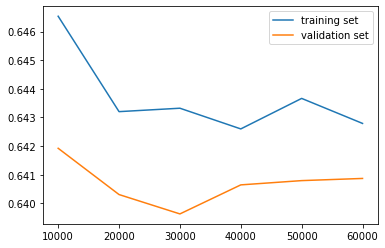

In [52]:
##########################
# A FAIRE : 
# - faire une fonction pour la learning_curve_cv et learning_curve_dataset
# - vérifier que les X et y doivent bien être renseignés par le X_train et le y_train
# - Afin d'analyser plus finement nos trois métriques, faire un tableau matplotlib avec une learning curve pour chacune
#########################


from sklearn.model_selection import learning_curve

# learning curve returns : train_size, train_score, test_score

train_sizes, train_scores, validation_scores = learning_curve(estimator = model, 
                                                              X = X_train,
                                                              y = y_train.values.ravel(),
                                                              train_sizes = ([10000,20000,30000,40000,50000, 60000]),
                                                              cv = 5,
                                                              scoring = 'precision')

plt.plot(train_sizes,np.mean(train_scores,axis=1), label= 'training set')
plt.plot(train_sizes,np.mean(validation_scores,axis=1), label= 'validation set')
plt.legend()
plt.show()

In [53]:
# avec la precision : bonne convergence entre les 2 courbes -> montre une tendance

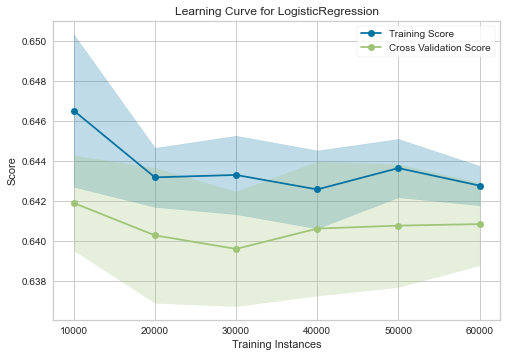

In [54]:
from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

train_sizes = ([10000,20000,30000,40000,50000, 60000])

visualizer = LearningCurve(
    model, cv=5, scoring='precision', train_sizes=train_sizes, n_jobs=4
)

visualizer.fit(X_train, y_train) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

In [55]:
#########################
# Vérifier que cette étape est bien à indiquer ici
#########################

# Lorsque les résultats sont probants avec la cross validation, on peut scorer sur notre jeu de test (y_test). 

SyntaxError: invalid syntax (3979109684.py, line 5)

### Score sur le test

In [123]:
# score sur mon jeu de test

score = model.score(X_test,y_test)
score

0.6102697465708021

**Interprétation**  
A priori, notre modèle ne semble pas overfitter : le score en cross validation et sur le jeu de test final ne montrent pas de surapprentissage et le modèle semble bien généraliser car nous avons à peu près les mêmes scores. 
L'accuracy  mériterait toutefois d'être améliorée, notamment grâce à l'optimisation des hyperparamètres et avec un preprocessing plus élaboré. 

#### Learning curve sur le test

#### Métriques de performance

In [ ]:
# reprendre celles vues précédemment => faire des fonctions pour récupérer les bons paramètres avec un paramètres 
# optionnel pour la cross_validation ? 

Mon modèle généralise bien, je peux donc l'entraîner sur l'ensemble de mon dataset et enregistrer mon predict. Avec une accuracy de 0.6, je peux avoir confiance en mon modèle à 60% (vérifier cette interprétation qui me semble peu précise). 

### Score sur l'ensemble du data set

In [124]:
# model.fit(X, y)

model.fit(X,y.values.ravel())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  array([], dtype=object))])),
                ('logisticregression', LogisticRegression(random_state=5))])

In [125]:
model.score(X, y)

0.61320523803696

### Predict

In [126]:
# Renvoie la prediction du label en fonction de X

model.predict(X)[25]

0

In [ ]:
# Renvoie une probabilité pour chaque label
# Interprétation : L'item 25 a 56% d'appartenir à la classe 0 et 43% d'appartenir à la classe 1.

model.predict_proba(X)[25]

In [ ]:
# Exemple predict avec une variable = tester

'''
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
reg = linear_model.LinearRegression()
reg.fit(data[["OverallQual"]], data["Log_SalePrice"])
print(f'R2 ==> {reg.score(data[["OverallQual"]], data["Log_SalePrice"])}')
'''

In [ ]:
'''
# Essayons de prédire le prix d'une maison affichant une qualité de 6:
def price_predict():
    quality = float(input("Indiquez la qualité de votre bien - Nombre de 0 à 10 ==> "))    
    result = reg.predict([[quality]])
    result = np.exp(result)
    print(f"Le prix que vous pouvez obtenir pour votre maison est estimé à environ {result} dollars")
price_predict()
'''

### Sauvegarde du modèle

**Avec Pickle**

In [ ]:
# Avec pickle

import pickle

In [ ]:
# Enregistre mon modèle dans un fichier au format pickle
'''
with open('model_pickle', 'wb') as f: # wb : write in file
    pickle.dump(model, f) # dump = déposer le modèle dans le ficher

In [ ]:
# Charge le modèle pickle 
'''
with open('model_pickle', 'rb') as f : # read file
    model_pickle = pickle.load(f)

In [ ]:
# Le fichier pickle a enregistré le modèle qui se trouvait dans le fit (pipeline + regression logistique)

model_pickle

In [ ]:
model_pickle.predict(X)

**Avec Joblib**

In [ ]:
##################
# CREER FONCTION
#################

In [127]:
import joblib 

In [128]:
# Sauvegarde du modèle sous le fichier nommé 'model_joblib'

joblib.dump(model, 'model_joblib')

['model_joblib']

In [129]:
# Lecture du modèle enregistré dans le fichier

model_joblib = joblib.load('model_joblib')

In [130]:
# Visualisation du modèle tel qu'il a été enregistré

model_joblib

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  array(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'age'], dtype=object)),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  array([], dtype=object))])),
                ('logisticregression', LogisticRegression(random_state=5))])

In [135]:
# Test avec un autre dataset 

def predict(time_in_hospital=3, num_lab_procedures=4, num_procedures=5, num_medications=6,
            number_outpatient = 8, number_emergency=2, number_inpatient=4, number_diagnoses=3, age=25):
    
    data = [[time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency,
           number_inpatient, number_diagnoses, int(age)]]
    data = pd.DataFrame(data, columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                                         'num_medications', 'number_outpatient', 'number_emergency',
                                           'number_inpatient', 'number_diagnoses', 'age'])
    
    model_joblib = joblib.load('model_joblib')
    
    prediction = model_joblib.predict(data)
    
    return prediction

return A+1 if A > B else A-1

predict()

SyntaxError: EOL while scanning string literal (1601708969.py, line 16)

## Les présupposés de la régression logistique

In [ ]:
baseline.head()

In [ ]:
# Test d'entrainement avec une feature pour input 1 feature dans l'Api (pour la compréhension de la méthode)
# Avec le X_train
# 'time_in_hospital'

fit_1_feature = model.fit(baseline['number_diagnoses'], baseline['readmitted'])
# fit_1_feature

## Analyse avec statmodel ? 

## Analyse de cette première itération & actions à mener

# Idées en vrac

In [ ]:
# Voir si nécessité d'ajouter en intro une partie sur la compréhension de la problématique (voir livre de Geron
# et Machine Learnia) 

# Pour le nettoyage des données : 
    # Voir comment gérer la colonne 'race' : pour le même id = pas la même race attribuée

## Feature engineering

In [ ]:
# Nombre d'admissions par patient
# Filtrer pour n'ajouter que ceux qui ont une admission supérieure à 1 
# Connaitre le nombre de patient par nombre d'admission (groupeby n?)
# df.patient_nbr.value_counts()

# Très peu de données sur le poids mais peut-être intéressant d'indiquer cette variable => voir si
# suffisamment probant en termes de représentabilité de classe d'age pour le remplacer ?? 

## Variables qualitatives

In [ ]:
# Pour la correlation entre mes variables qualitatives et ma target, utiliser la fonction crosstab (vu avec Machine
# Learnia) + tenter le Khi-2

## Outils

In [ ]:
# pandas profiling 
# retrouver bibliothèque qui permet de faire viz rapidement (check) pour l'EDA de la baseline

# Catalogue des fonctions

In [ ]:
# Datavisualisation

def analyse_dtypes_object(data):
    return data.select_dtypes(include=('object')).nunique().sort_values(ascending=False)

def analyse_target(data) : 
    number = data.readmitted.value_counts()
    percentage = data.readmitted.value_counts(normalize=True).round(3)*100
    analyse_target = {'number': number, '%': percentage}
    analyse_target_1 = pd.DataFrame(analyse_target)
    return analyse_target_1

def map_missing_values(data):
    plt.figure(figsize=(17,7))
    heatmap = sns.heatmap(data.isna(), cbar=False, cmap="Blues")
    heatmap.set_title('Heatmap des valeurs manquantes du dataset',
    fontdict={'fontsize':18}, pad=16);

def check_null_values(df):
    nb_null = df.isnull().sum().sort_values(ascending=False).head(10)
    percentage_null = df.isnull().sum()*100/len(df)
    percentage_null = percentage_null.sort_values(ascending=False).head(10).round(1)
    null = {'nombre_null' : nb_null,'%_null' : percentage_null}
    data = pd.DataFrame(data = null)
    return data
    
# Preprocessing

def columns_with_interrogation(df):
    list = []
    [list.append(i) for i in df.columns if np.any(df[i] == '?')]

def modalites(df):
    for i in df.columns:
        print(f'{i}: {df[i].unique()}')
        print(f'Nb de modalités : {df[i].value_counts().count()}\n')